# Running Biomechanics Data Set processed files

Reginaldo K Fukuchi, Jan 2023, reginaldo.fukuchi@ufabc.edu.br

This NB prepares data to e exported as RBDSxxxxprocessed.txt

In [114]:
# Prepare environment
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [115]:
subject = 'SUB0043'
side   = ['Right','Left'];

In [116]:
if subject=='SUB0042' or subject=='SUB0041':
    speed = [25,35,45];
else:
    speed = [35];

In [117]:
# Import data
pathname = r'C:\Users\Reginaldo\Documents\data\CNPq\RBDS_v2\RBA';
pathDir = os.path.join(pathname, subject)

In [118]:
joints = ['hip','knee','ankle'];
varListRBA = ['Stride_Length','Strides_Per_Minute','Stride_Width'];
direction = ['X','Y','Z']

## Emsemble avg angles, moments, powers and GRFs

In [119]:
# preallocate
angs_data = np.empty(shape=(101,len(speed),len(side),len(joints),len(direction),1))*np.NaN
moms_data = np.empty(shape=(101,len(speed),len(side),len(joints),len(direction),1))*np.NaN
pows_data = np.empty(shape=(101,len(speed),len(side),len(joints),1))*np.NaN
grfs_data = np.empty(shape=(101,len(speed),len(side),len(direction),1))*np.NaN

grfs_trials= np.empty(shape=(101,len(speed),len(side),len(direction),100))*np.NaN 

for v, velo in enumerate(speed):
    # Import Temporal Distance Gait Parameters
    # Read columns
    filename = os.path.join(pathDir,'RUNT'+str(speed[v])+'tempSpatGaitParams.txt')
    head_SPTparams = pd.read_csv(filename, delimiter='\t', header=1)
    SPTparams_labels = head_SPTparams.columns.tolist()
    # Read data only
    data_SPTparams = pd.read_csv(filename, delimiter='\t', skiprows=4)
    # Create another df
    df_SPT = pd.DataFrame(data=data_SPTparams.values, columns=SPTparams_labels)
    df_SPT.drop(labels='Unnamed: 0', axis=1, inplace=True)

    spt_labels = []
    for s, sid in enumerate(side):
        #### SPATIOTEMPORAL PARAMETERS
        for stp, stpars in enumerate(varListRBA):
            if stpars=='Stride_Width':
                varFullName = stpars + '_Mean'
            else:
                varFullName = sid+'_'+stpars+'_Mean'
            # Columns names of the STP of interest
            spt_labels.append(varFullName)


        for j, joint in enumerate(joints):        

            # Filename for angles
            fname_angs= os.path.join(pathDir,'RUN'+str(speed[v])+sid[0]+joint+'Ang.txt')
            df_angs   = pd.read_csv(fname_angs, delimiter='\t', skiprows=4)
            df_angs   = df_angs.iloc[:,1:]
            # Filename for moments
            fname_moms= os.path.join(pathDir,'RUN'+str(speed[v])+sid[0]+joint+'Mom.txt')
            df_moms   = pd.read_csv(fname_moms, delimiter='\t', skiprows=4)
            df_moms   = df_moms.iloc[:,1:]
            # Filename for powers
            fname_pows= os.path.join(pathDir,'RUN'+str(speed[v])+sid[0]+joint+'Pow.txt')
            df_pows   = pd.read_csv(fname_pows, delimiter='\t', skiprows=4)
            df_pows   = df_pows.iloc[:,1:]

            if joint=='hip': # Filename for GRFs        
                fname_grfs= os.path.join(pathDir,'RUN'+str(speed[v])+sid[0]+'grf.txt')
                df_grfs   = pd.read_csv(fname_grfs, delimiter='\t', skiprows=4)
                df_grfs   = df_grfs.iloc[:,1:]

            for xyz, axes in enumerate(direction):
                angs_data[:, v, s, j, xyz, 0] = df_angs.iloc[:,xyz::3].mean(axis=1, skipna=True)
                moms_data[:, v, s, j, xyz, 0] = df_moms.iloc[:,xyz::3].mean(axis=1, skipna=True)
            pows_data[:, v, s, j, 0] = df_pows.mean(axis=1, skipna=True)
            grfs_data[:, v, s, j, 0] = df_grfs.iloc[:,j::3].mean(axis=1, skipna=True)
            
            grfs_trials[:, v, s, j, 0:int(df_grfs.shape[1]/3)] = df_grfs.iloc[:,j::3]

stp_params = df_SPT[spt_labels]

C:\Users\Reginaldo\AppData\Local\Temp\ipykernel_14164\2583892020.py:7: RuntimeWarning: invalid value encountered in multiply
  grfs_trials= np.empty(shape=(101,len(speed),len(side),len(direction),100))*np.NaN


#### Column names consistent to the processed files in the RBDS study

In [120]:
cols = ['hipAngX', 'hipAngY', 'hipAngZ', 'kneeAngX', 'kneeAngY', 'kneeAngZ',
           'ankleAngX', 'ankleAngY', 'ankleAngZ', 'hipMomX', 'hipMomY', 'hipMomZ',
           'kneeMomX', 'kneeMomY', 'kneeMomZ', 'ankleMomX', 'ankleMomY', 'ankleMomZ',
           'grfX', 'grfY', 'grfZ', 'hipPow', 'kneePow', 'anklePow']

# List comprehension with column labels
columns = [side[s][0]+c+str(speed[v]) for s in range(len(side)) for v in range(len(speed)) for c in cols]

### Create array with angles, moments, GRFs and powers with order consistent with processed files

In [121]:
ncols_side = len(speed)*((len(joints)*len(direction)+len(joints)*len(direction))+len(direction)+len(joints))
side_data = np.empty(shape=(101,ncols_side*len(side)))
for s, sid in enumerate(side):
    speed_data = np.empty(shape=(101,24*len(speed)))
    for v, velo in enumerate(speed):
        angs = np.empty(shape=(101,len(joints)*len(direction)))
        moms = np.empty(shape=(101,len(joints)*len(direction)))
        pows = np.empty(shape=(101,len(joints)))
        grfs = np.empty(shape=(101,len(direction)))
        for j, joint in enumerate(joints):
            for xyz, axes in enumerate(direction):
                angs[:,3*j+xyz] = angs_data[:, v, s, j, xyz, 0] # Angles
                moms[:,3*j+xyz] = moms_data[:, v, s, j, xyz, 0] # Moments
                
            pows[:,j] = pows_data[:, v, s, j, 0] # Powers
            grfs[:,j] = grfs_data[:, v, s, j, 0] # GRFs
            
        speed_data[:, 24*v:24*(v+1)] = np.hstack([angs, moms, grfs, pows])
    side_data[:, ncols_side*s:ncols_side*(s+1)] = speed_data

### Create df

In [122]:
df_rbds = pd.DataFrame(data=side_data, columns=columns).round(6)
df_rbds['PercGcycle'] = list(range(0,101))
df_rbds.set_index('PercGcycle', inplace=True)
# Export to txt
path_D = r'C:\Users\Reginaldo\Documents\data\CNPq\RBDS_v2\Figshare_update'
df_rbds.to_csv(os.path.join(path_D,'RBDS0'+subject[-2:]+'processed.txt'), sep='\t')
df_rbds.head()

,RhipAngX35,RhipAngY35,RhipAngZ35,RkneeAngX35,RkneeAngY35,RkneeAngZ35,RankleAngX35,RankleAngY35,RankleAngZ35,RhipMomX35,...,LkneeMomZ35,LankleMomX35,LankleMomY35,LankleMomZ35,LgrfX35,LgrfY35,LgrfZ35,LhipPow35,LkneePow35,LanklePow35
PercGcycle,,,,,,,,,,,,,,,,,,,,,
0,10.131896,0.681267,48.715873,0.621834,-25.728939,19.849296,10.620442,13.781187,18.914992,0.035701,...,-0.511044,0.025572,-0.014321,0.015943,-0.198402,0.704428,0.025538,1.192878,1.718631,0.066111
1,10.475307,1.759371,48.184607,0.934702,-25.961526,21.142445,9.157813,13.525785,17.640455,0.147257,...,-0.461458,0.016434,-0.032417,-0.046264,-0.296567,1.880527,0.043409,1.348707,1.919794,-0.205720
2,10.880562,2.615369,47.512791,1.207937,-25.912779,22.731227,7.110012,13.130913,15.804813,0.286456,...,-0.398164,0.000596,-0.053122,-0.128034,-0.398489,3.651516,0.062718,1.443614,1.912381,-0.780558
3,11.342410,3.134843,46.732973,1.382149,-25.447184,24.585317,4.605085,12.525916,13.618560,0.456622,...,-0.287949,-0.020085,-0.069048,-0.211162,-0.514061,5.971814,0.073836,1.378934,1.529583,-1.417555
4,11.836973,3.257509,45.916369,1.426221,-24.527673,26.719000,1.884232,11.686020,11.443501,0.654107,...,-0.092982,-0.041098,-0.075323,-0.266245,-0.682039,8.654163,0.072241,1.038967,0.427211,-1.665188


## Visualize data

In [123]:
cor = ['b','r','k']

## Hip, knee and ankle angles

<IPython.core.display.Javascript object>


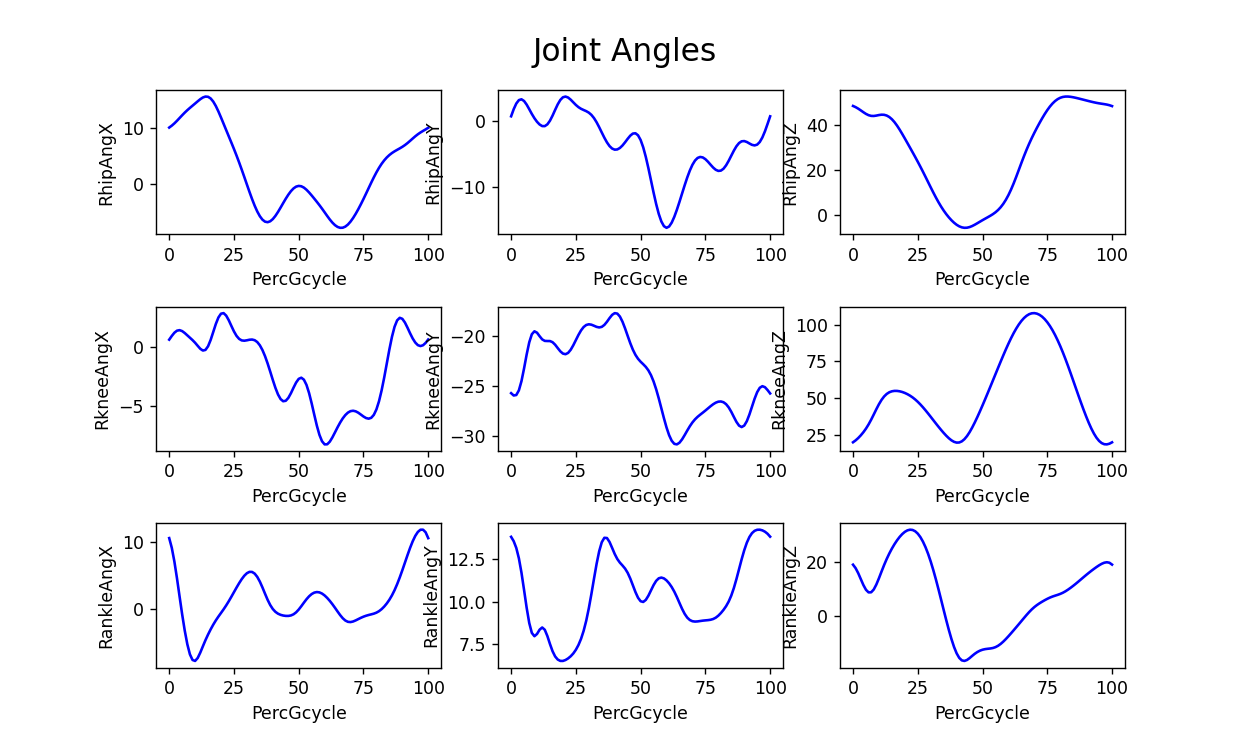

In [124]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Joint Angles", fontsize=18, y=0.95)

for j, joint in enumerate(joints):
    for xyz, axes in enumerate(direction):
        for v, vel in enumerate(speed):
            df_rbds.plot(y='R'+joint+'Ang'+axes+str(vel), use_index=True, ax=axs[j,xyz], 
                         legend=False, color=cor[v], ylabel='R'+joint+'Ang'+axes)

## Hip, knee and ankle moments

<IPython.core.display.Javascript object>


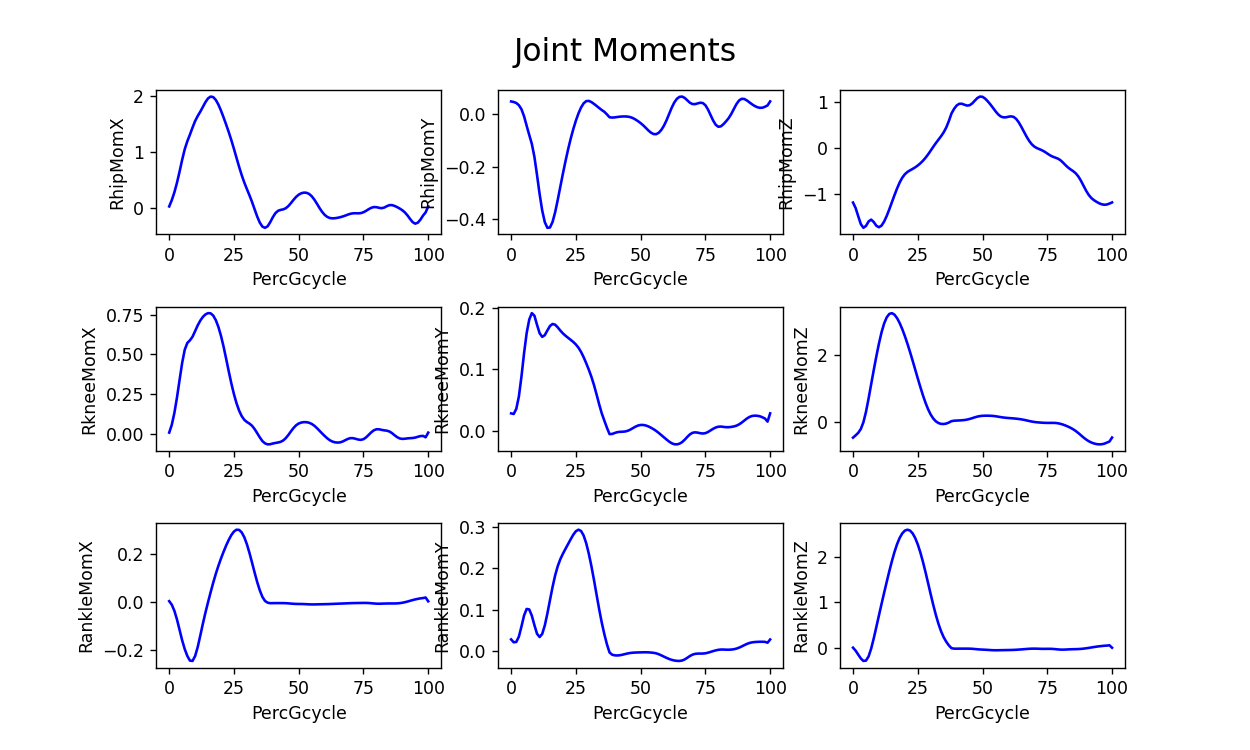

In [125]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Joint Moments", fontsize=18, y=0.95)

for j, joint in enumerate(joints):
    for xyz, axes in enumerate(direction):
        for v, vel in enumerate(speed):
            df_rbds.plot(y='R'+joint+'Mom'+axes+str(vel), use_index=True, ax=axs[j,xyz], 
                         legend=False, color=cor[v], ylabel='R'+joint+'Mom'+axes)

## Hip, knee and ankle powers

<IPython.core.display.Javascript object>


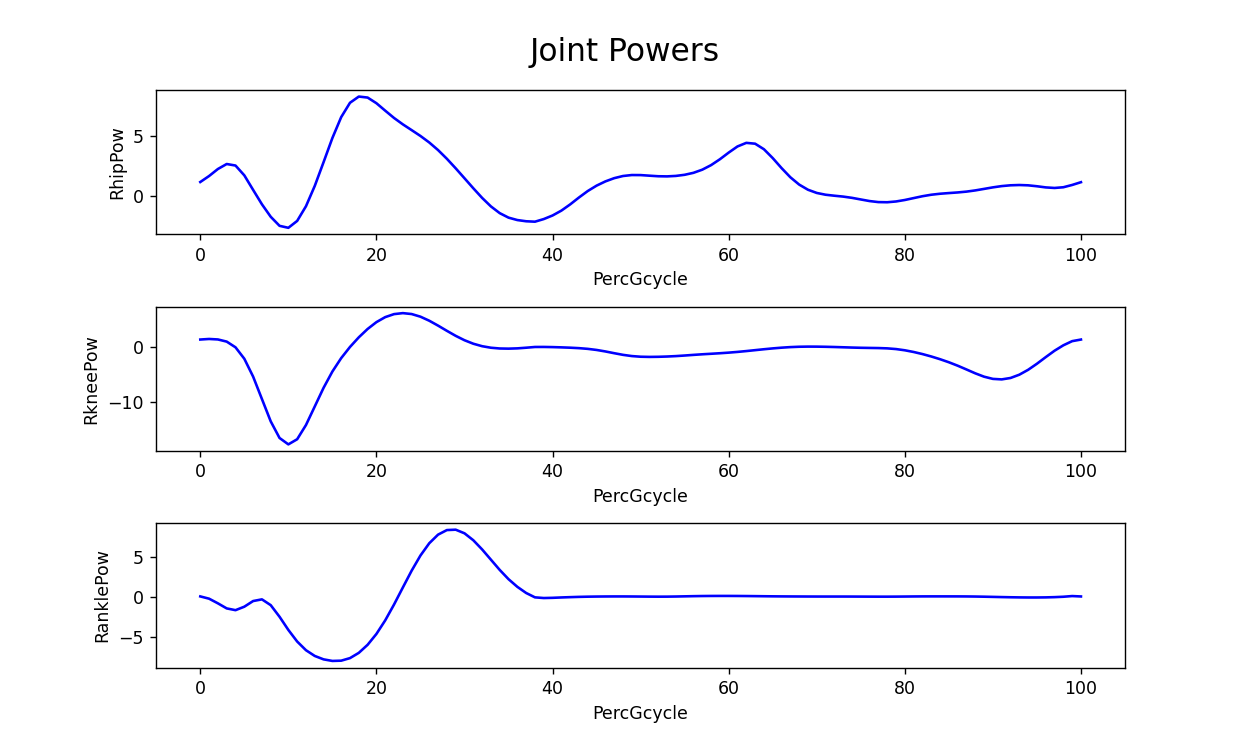

In [126]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Joint Powers", fontsize=18, y=0.95)

for j, joint in enumerate(joints):
    for v, vel in enumerate(speed):
        df_rbds.plot(y='R'+joint+'Pow'+str(vel), use_index=True, ax=axs[j], 
                     legend=False, color=cor[v], ylabel='R'+joint+'Pow')

## GRFs

<IPython.core.display.Javascript object>


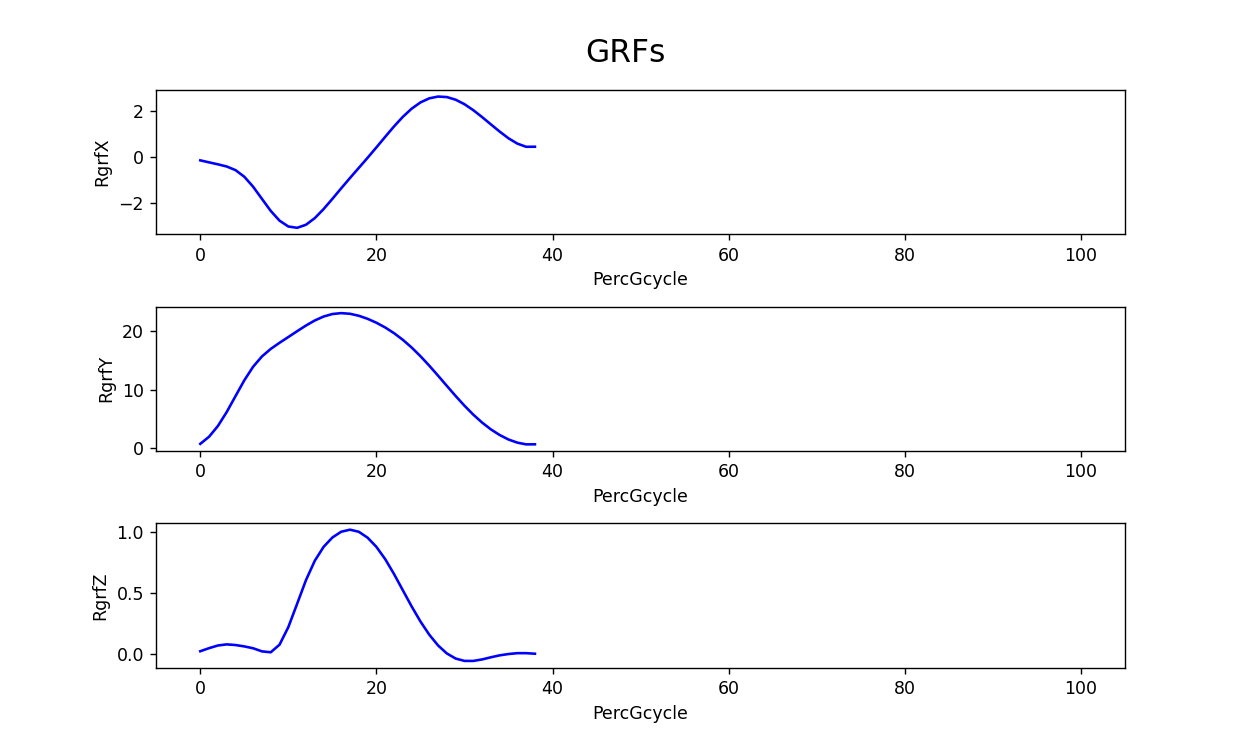

In [127]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("GRFs", fontsize=18, y=0.95)

for xyz, axes in enumerate(direction):
    for v, vel in enumerate(speed):
        df_rbds.plot(y='R'+'grf'+axes+str(vel), use_index=True, ax=axs[xyz], 
                     legend=False, color=cor[v], ylabel='R'+'grf'+axes)
        
plt.show()